# Image classification


In [1]:
# Imports et chemins
import sys
from pathlib import Path
sys.path.append(str(Path('..').resolve()))
from collections import Counter
import random
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from model.image.models import create_model
from model.image.dataset import SimpleImageFolder
from PIL import Image

base_dir = Path("../data/ImagensTCCRotuladas").resolve()
classes = ["Chao", "Milho", "Ervas", "Milho_ervas"]

split_dirs = {
    "train": base_dir / "Treino",
    "val": next((p for p in base_dir.iterdir() if p.name.lower().startswith("valid")), None),
    "test": base_dir / "Teste",
}
print("Base dir:", base_dir)
print("Splits:", split_dirs)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Base dir: C:\Users\lmanuelli\Projet\TP_final\data\ImagensTCCRotuladas
Splits: {'train': WindowsPath('C:/Users/lmanuelli/Projet/TP_final/data/ImagensTCCRotuladas/Treino'), 'val': WindowsPath('C:/Users/lmanuelli/Projet/TP_final/data/ImagensTCCRotuladas/Valida├º├úo'), 'test': WindowsPath('C:/Users/lmanuelli/Projet/TP_final/data/ImagensTCCRotuladas/Teste')}
Device: cpu


exploration des splits


In [ ]:
# Exploration : comptages et contrôles
from typing import Dict, List

def collect_files(split: str) -> Dict[str, List[Path]]:
    root = split_dirs[split]
    per_class = {}
    for cls in classes:
        per_class[cls] = sorted([p for p in (root / cls).glob("*") if p.suffix.lower() in {".jpg", ".jpeg", ".png"}])
    return per_class

train_files = collect_files("train")
val_files = collect_files("val") if split_dirs["val"] else {}
test_files = collect_files("test")

train_counts = {cls: len(paths) for cls, paths in train_files.items()}
val_counts = {cls: len(paths) for cls, paths in val_files.items()} if val_files else {}
test_counts = {cls: len(paths) for cls, paths in test_files.items()}

print("Train counts:", train_counts)
print("Val counts:", val_counts)
print("Test counts:", test_counts)
print("Total train samples:", sum(train_counts.values()))
min_train = min(train_counts.values())
print("Smallest train class size:", min_train)

extra_dirs = [p for p in split_dirs["train"].iterdir() if p.is_dir() and p.name not in classes]
print("R?pertoires inattendus dans train:", [p.name for p in extra_dirs])
(train_counts, val_counts, test_counts)


Train counts: {'Chao': 6134, 'Milho': 6255, 'Ervas': 6015, 'Milho_ervas': 6040}
Val counts: {'Chao': 646, 'Milho': 695, 'Ervas': 668, 'Milho_ervas': 670}
Test counts: {'Chao': 101, 'Milho': 100, 'Ervas': 100, 'Milho_ervas': 100}
Total train samples: 24444
Smallest train class size: 6015
R?pertoires inattendus dans train: []


({'Chao': 6134, 'Milho': 6255, 'Ervas': 6015, 'Milho_ervas': 6040},
 {'Chao': 646, 'Milho': 695, 'Ervas': 668, 'Milho_ervas': 670},
 {'Chao': 101, 'Milho': 100, 'Ervas': 100, 'Milho_ervas': 100})

Répartition des splits

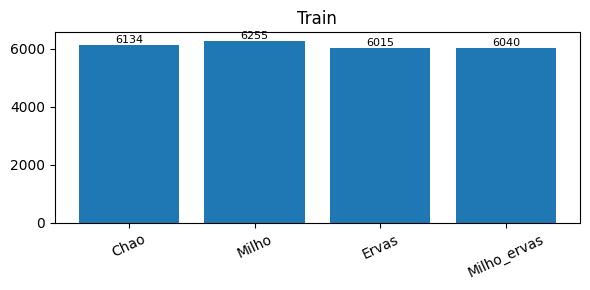

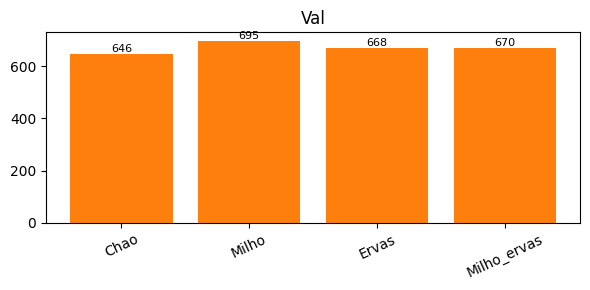

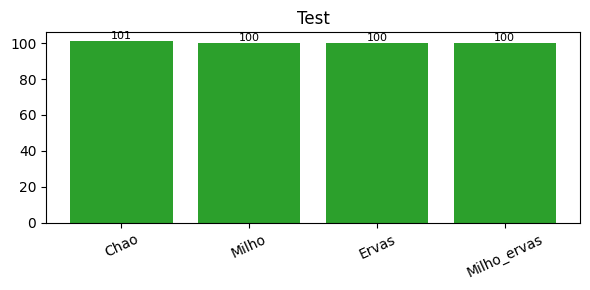

In [3]:
# Bar charts par split
import numpy as np

def plot_counts(counts: dict, title: str, color: str):
    labels = list(counts.keys())
    values = [counts[k] for k in labels]
    plt.figure(figsize=(6, 3))
    plt.bar(labels, values, color=color)
    plt.title(title)
    plt.xticks(rotation=25)
    for i, v in enumerate(values):
        plt.text(i, v, str(v), ha='center', va='bottom', fontsize=8)
    plt.tight_layout(); plt.show()

plot_counts(train_counts, 'Train', 'tab:blue')
if val_counts:
    plot_counts(val_counts, 'Val', 'tab:orange')
plot_counts(test_counts, 'Test', 'tab:green')


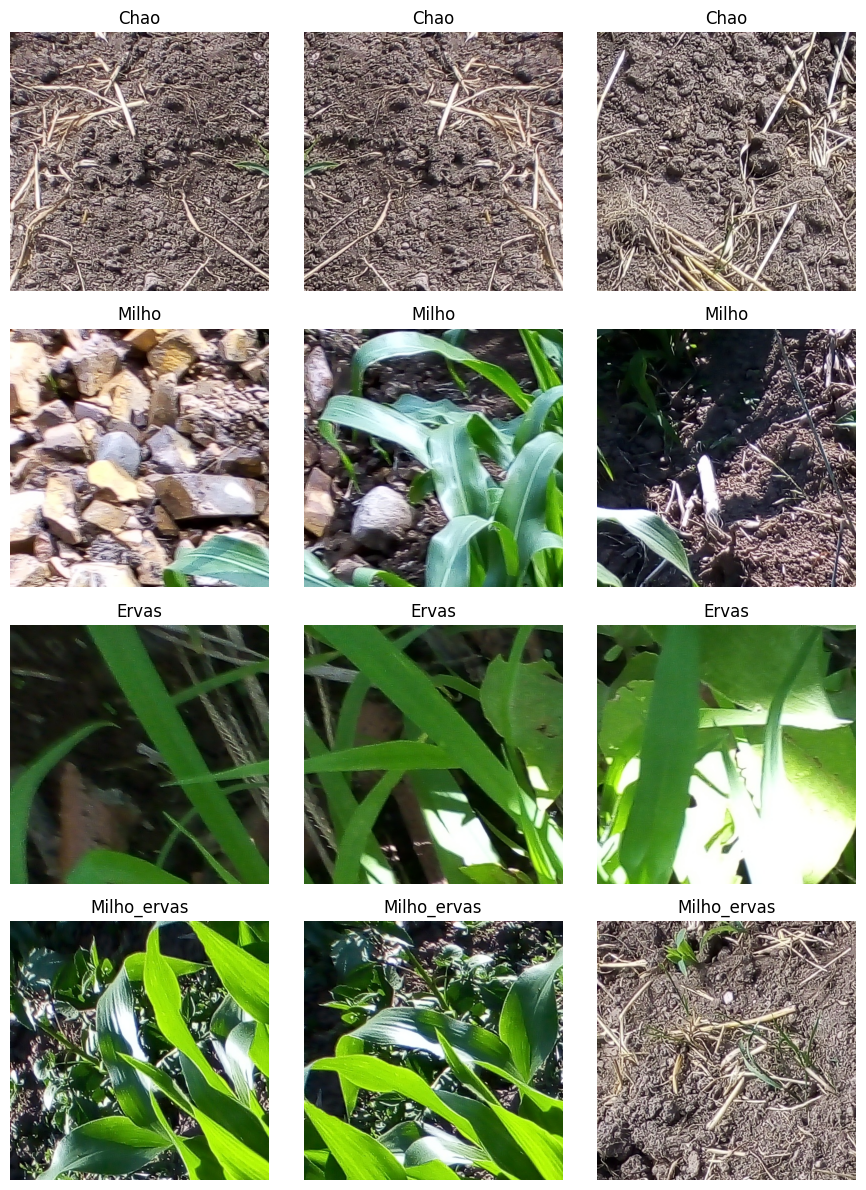

In [ ]:
# échantillons visuels train
n_per_class = 3
fig, axes = plt.subplots(len(classes), n_per_class, figsize=(3 * n_per_class, 3 * len(classes)))
for row, cls in enumerate(classes):
    files = train_files.get(cls, [])[:n_per_class]
    for col, path in enumerate(files):
        ax = axes[row, col] if len(classes) > 1 else axes[col]
        ax.imshow(Image.open(path))
        ax.axis("off")
        ax.set_title(cls)
plt.tight_layout(); plt.show()


loader équilibré sans bruit


In [5]:
# Build loaders balanced clean
class AddWhiteNoise:
    def __init__(self, std: float = 0.0):
        self.std = std
    def __call__(self, tensor):
        noise = torch.randn_like(tensor) * self.std
        return torch.clamp(tensor + noise, 0.0, 1.0)

def build_loader(split: str, image_size: int, batch_size: int, per_class_limit: int | None, balance: bool, noise_std: float | None, seed: int = 42):
    split_path = split_dirs[split]
    rng = random.Random(seed)
    paths, labels = [], []
    for cls in classes:
        files = sorted([p for p in (split_path / cls).glob("*") if p.suffix.lower() in {'.jpg', '.jpeg', '.png'}])
        if per_class_limit:
            files = files[:per_class_limit]
        if balance:
            target = per_class_limit or min_train
            rng.shuffle(files)
            files = files[:target]
        for p in files:
            paths.append(p)
            labels.append(classes.index(cls))

    transform_steps = [transforms.Resize((image_size, image_size)), transforms.ToTensor()]
    if split == 'train' and noise_std:
        transform_steps.append(AddWhiteNoise(noise_std))
    transform = transforms.Compose(transform_steps)

    dataset = SimpleImageFolder(paths, labels, image_size=image_size)
    dataset.transform = transform
    return DataLoader(dataset, batch_size=batch_size, shuffle=(split == 'train'))

train_loader = build_loader('train', image_size=128, batch_size=32, per_class_limit=2000, balance=True, noise_std=0.0)
val_loader = build_loader('val', image_size=128, batch_size=32, per_class_limit=2000, balance=False, noise_std=None)
print(f'Train size: {len(train_loader.dataset)}')
print(f'Val size: {len(val_loader.dataset)}')


Train size: 8000
Val size: 2679


In [6]:
# V?rification ?quilibre (train_loader)
counts = Counter(train_loader.dataset.labels)
print({classes[i]: c for i, c in counts.items()})


{'Chao': 2000, 'Milho': 2000, 'Ervas': 2000, 'Milho_ervas': 2000}


loader équilibré avec bruit blanc


In [7]:
# Build loaders balanced noise
class AddWhiteNoise:
    def __init__(self, std: float = 0.03):
        self.std = std
    def __call__(self, tensor):
        noise = torch.randn_like(tensor) * self.std
        return torch.clamp(tensor + noise, 0.0, 1.0)

def build_loader(split: str, image_size: int, batch_size: int, per_class_limit: int | None, balance: bool, noise_std: float | None, seed: int = 42):
    split_path = split_dirs[split]
    rng = random.Random(seed)
    paths, labels = [], []
    for cls in classes:
        files = sorted([p for p in (split_path / cls).glob("*") if p.suffix.lower() in {'.jpg', '.jpeg', '.png'}])
        if per_class_limit:
            files = files[:per_class_limit]
        if balance:
            target = per_class_limit or min_train
            rng.shuffle(files)
            files = files[:target]
        for p in files:
            paths.append(p)
            labels.append(classes.index(cls))

    transform_steps = [transforms.Resize((image_size, image_size)), transforms.ToTensor()]
    if split == 'train' and noise_std:
        transform_steps.append(AddWhiteNoise(noise_std))
    transform = transforms.Compose(transform_steps)

    dataset = SimpleImageFolder(paths, labels, image_size=image_size)
    dataset.transform = transform
    return DataLoader(dataset, batch_size=batch_size, shuffle=(split == 'train'))

train_loader = build_loader('train', image_size=128, batch_size=32, per_class_limit=2000, balance=True, noise_std=0.03)
val_loader = build_loader('val', image_size=128, batch_size=32, per_class_limit=2000, balance=False, noise_std=None)
print(f'Train size: {len(train_loader.dataset)}')
print(f'Val size: {len(val_loader.dataset)}')


Train size: 8000
Val size: 2679


In [ ]:
# Vérification équilibré (train_loader)
counts = Counter(train_loader.dataset.labels)
print({classes[i]: c for i, c in counts.items()})


{'Chao': 2000, 'Milho': 2000, 'Ervas': 2000, 'Milho_ervas': 2000}


In [ ]:
# Entraînement

def evaluate(model: torch.nn.Module, loader: DataLoader):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            pred = logits.argmax(dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    return labels, preds

def train_fast(epochs: int = 2, lr: float = 1e-3, dropout: float = 0.3):
    model = create_model(num_classes=len(classes), dropout=dropout, use_pretrained=True).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    history = {"train_loss": [], "val_acc": []}
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = loss_fn(logits, y)
            loss.backward()
            opt.step()
            opt.zero_grad()
            running_loss += loss.item()
        avg_loss = running_loss / max(1, len(train_loader))
        labels, preds = evaluate(model, val_loader)
        val_acc = accuracy_score(labels, preds)
        history["train_loss"].append(avg_loss)
        history["val_acc"].append(val_acc)
        print(f"Epoch {epoch+1}/{epochs} - loss={avg_loss:.4f} val_acc={val_acc:.3f}")
    return model, history

model, history = train_fast(epochs=2, lr=1e-3, dropout=0.3)


Epoch 1/2 - loss=0.6405 val_acc=0.614
Epoch 2/2 - loss=0.4392 val_acc=0.739


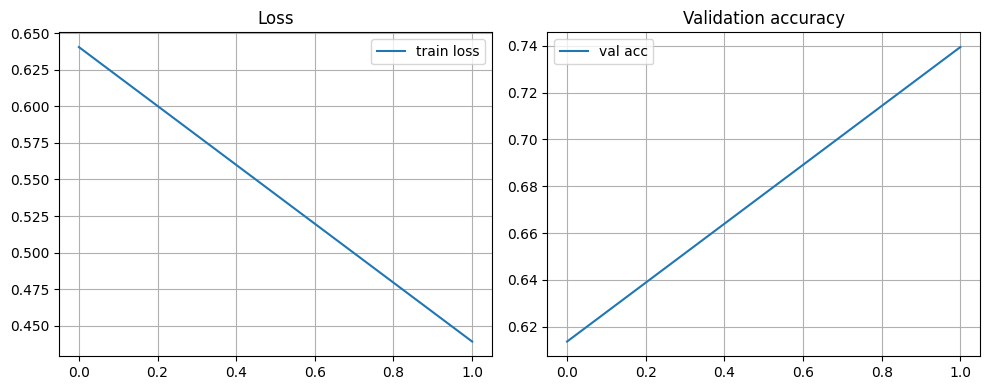

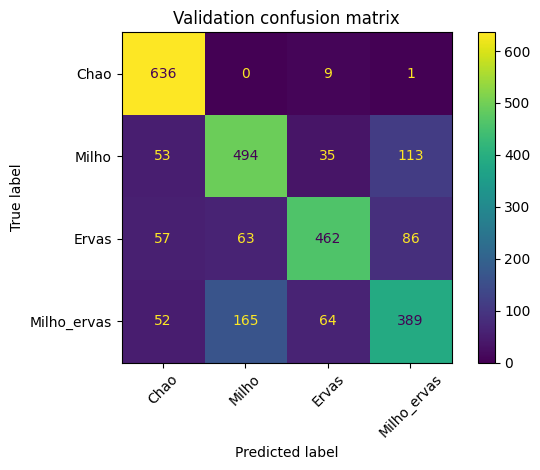

In [10]:
# Courbes et matrice de confusion (val)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(history["train_loss"], label="train loss")
axes[0].set_title("Loss")
axes[1].plot(history["val_acc"], label="val acc")
axes[1].set_title("Validation accuracy")
for ax in axes: ax.legend(); ax.grid(True)
plt.tight_layout(); plt.show()

labels, preds = evaluate(model, val_loader)
cm = confusion_matrix(labels, preds)
ConfusionMatrixDisplay(cm, display_labels=classes).plot(xticks_rotation=45)
plt.title("Validation confusion matrix")
plt.tight_layout(); plt.show()


In [11]:
# Rapport par classe (val)
val_labels, val_preds = evaluate(model, val_loader)
print(classification_report(val_labels, val_preds, target_names=classes, digits=3))


              precision    recall  f1-score   support

        Chao      0.797     0.985     0.881       646
       Milho      0.684     0.711     0.697       695
       Ervas      0.811     0.692     0.746       668
 Milho_ervas      0.660     0.581     0.618       670

    accuracy                          0.739      2679
   macro avg      0.738     0.742     0.736      2679
weighted avg      0.737     0.739     0.734      2679



              precision    recall  f1-score   support

        Chao      0.833     0.990     0.905       101
       Milho      0.553     0.730     0.629       100
       Ervas      0.852     0.690     0.762       100
 Milho_ervas      0.706     0.480     0.571       100

    accuracy                          0.723       401
   macro avg      0.736     0.723     0.717       401
weighted avg      0.736     0.723     0.718       401



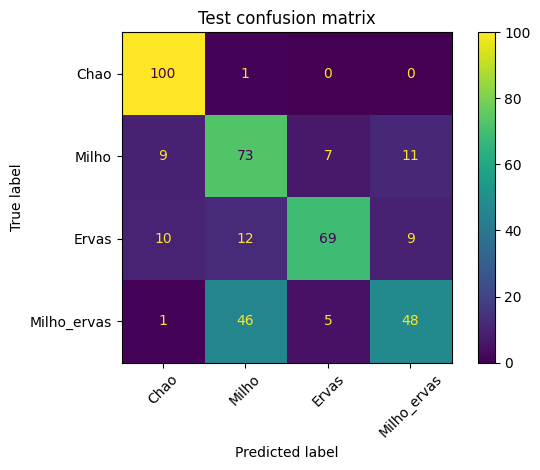

In [12]:
# ?valuation compl?te sur test
test_loader = build_loader('test', image_size=128, batch_size=32, per_class_limit=None, balance=False, noise_std=None)
test_labels, test_preds = evaluate(model, test_loader)
print(classification_report(test_labels, test_preds, target_names=classes, digits=3))
cm_test = confusion_matrix(test_labels, test_preds)
ConfusionMatrixDisplay(cm_test, display_labels=classes).plot(xticks_rotation=45)
plt.title('Test confusion matrix')
plt.tight_layout(); plt.show()
